In [5]:
import sys
import os

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
dir_parent = os.path.dirname(dir_notebook)
if not dir_parent in sys.path:
    sys.path.append(dir_parent)

from PyQt5.QtWidgets import QMainWindow, QWidget, QGridLayout, QVBoxLayout, QHBoxLayout, QApplication
from optic.config import *
from optic.controls import *
from optic.dialog import *
from optic.gui import *
from optic.io import *
from optic.manager import *
from optic.gui.bind_func import *

class MicrogliaTrackingGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "MICROGLIA_TRACKING"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager, self.layout_manager = initManagers(
            WidgetManager(), ConfigManager(), DataManager(), ControlManager(), LayoutManager()
        )
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)

        self.initUI()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # file load UI
        self.layout_file_load = QHBoxLayout()
        self.setupFileLoadUI()
        self.layout_main.addLayout(self.layout_file_load, 1, 0, 1, 1)

        # main UI
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0, 1, 2)
        # extra UI (bottom)
        self.layout_extra_ui = QHBoxLayout()
        self.layout_main.addLayout(self.layout_extra_ui, 1, 1, 1, 1)

    def setupFileLoadUI(self):
        file_load_widget = QWidget()
        layout = QVBoxLayout(file_load_widget)

        layout.addLayout(self.makeLayoutSectionBottom())
        # bindFunc
        self.bindFuncFileLoadUI()

        self.layout_file_load.addWidget(file_load_widget)

    def loadFilePathsandInitialize(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)
        success = self.loadData()
        if success:
            QMessageBox.information(self, "File load", "File loaded successfully!")
            self.setupMainUI()
        else:
            QMessageBox.warning(self, "File Load Error", "Failed to load the file.")
            return

    def setupMainUI(self):
        if self.setupUI_done:
            # clear layouts
            clearLayout(self.layout_main_ui)
            clearLayout(self.layout_extra_ui)
        
        # set up main UI
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()

        self.setupUI_done = True

    def loadData(self):
        for app_key in self.app_keys:
            success = self.data_manager.loadTiffStack(
                app_key=app_key, 
                path_tiff=self.widget_manager.dict_lineedit[f"path_tiff"].text()
            )
        return success

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0, 1, 1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 1, 1, 1)
        self.layout_extra_ui.addLayout(self.makeLayoutSectionBottomExtra())

    def setupControls(self):
        len_t = self.data_manager.getSizeOfT(self.app_keys[0])
        for t in range(len_t):
            for app_key in self.app_keys:
                key = f"{app_key}_t{t}"
                self.control_manager.table_controls[key] = TableControl(
                    app_key=app_key,
                    q_table=self.widget_manager.dict_table[app_key],
                    data_manager=self.data_manager,
                    widget_manager=self.widget_manager,
                    config_manager=self.config_manager,
                    control_manager=self.control_manager,
                )
                
                self.control_manager.table_controls[key].setupWidgetDynamicTable(app_key)
                self.control_manager.view_controls[key] = ViewControl(
                    app_key=app_key,
                    q_view=self.widget_manager.dict_view[app_key], 
                    q_scene=self.widget_manager.dict_scene[app_key], 
                    data_manager=self.data_manager, 
                    widget_manager=self.widget_manager,
                    config_manager=self.config_manager,
                    control_manager=self.control_manager,
                    app_key_sec=self.app_keys[1] if app_key == self.app_keys[0] else None # only "pri" app_key has sec app_key
                )
                self.control_manager.view_controls[key].setViewSize()


    """
    makeLayout Function; Component
    小要素のLayout
    return -> Layout
    """

    "Bottom"
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()
        # Label
        layout.addWidget(self.widget_manager.makeWidgetLabel(key="load_tiff", label="File Load", font_size=12, bold=True, italic=True, use_global_style=False))
        # LineEdit
        label = "tiff stack (XYCT) file path"
        key = "path_tiff"
        layout.addLayout(makeLayoutLoadFileWidget(self.widget_manager, label=label, key_label=key, key_lineedit=key, key_button=key))
        # Button
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    "Left/Right Upper"
    # XYCT tiff stack view, slider
    def makeLayoutComponentImageView(self, app_key):
        layout = makeLayoutViewWithZTSlider(
            self.widget_manager, 
            app_key,
            slider_z=False,
            slider_t=True,
            key_label_t=f"{app_key}_plane_t",
            key_slider_t=f"{app_key}_plane_t",
            stack_size_t=self.data_manager.getSizeOfT(app_key),
            )
        return layout
    
    # channel contrast, ROI opacity slider
    def makeLayoutComponentContrastOpacitySlider(self, app_key):
        layout = QVBoxLayout()
        channels = self.config_manager.gui_defaults["CHANNELS"]
        layout_channel = QHBoxLayout()
        for channel in channels:
            layout_channel.addLayout(makeLayoutContrastSlider(
                self.widget_manager, 
                key_label=f"{app_key}_{channel}", 
                key_checkbox=f"{app_key}_{channel}", 
                key_slider=f"{app_key}_{channel}", 
                label_checkbox=f"Show {channel} channel", 
                label_label=f"{channel} Value", 
                checked=True
            ))

        layout.addLayout(layout_channel)
        layout.addLayout(makeLayoutOpacitySlider(
            self.widget_manager, 
            key_label=app_key, 
            key_slider=app_key, 
            label=app_key
        ))
        return layout

    # Table, ROI IO
    def makeLayoutComponentTable_Button(self, app_key):
        layout = QVBoxLayout()
        layout.addWidget(self.widget_manager.makeWidgetTable(app_key))
        return layout
    
    # View, slider
    def makeLayoutComponent_View_Slider(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentImageView(app_key))
        layout.addLayout(self.makeLayoutComponentContrastOpacitySlider(app_key))
        return layout
    
    "Bottom Extra"
    # Image Registration
    def makeLayoutComponenImageRegistration(self):
        layout = makeLayoutStackRegistration(
            self.widget_manager,
            self.data_manager,
            self.app_keys[0],                 
            f"elastix_registration",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",
            f"elastix_ref_plane_z",
            f"elastix_method",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",       
            f"elastix_ref_plane_z",        
            f"elastix_config", 
            f"elastix_run_t",   
            f"elastix_run_z",    
            f"export_reg_tiff",
            f"show_reg_result"
        )
        return layout
    
    # Optimal Transport ROI Matching
    def makeLayoutComponentROIMatching(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutROIMatching(
            self.widget_manager,
            "roi_matching",
            "ot_method",
            "fgwd_alpha",
            "wd_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "fgwd_alpha",
            "wd_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "ot_method",
            "ot_run",
            "ot_clear",
        ))
        layout.addLayout(makeLayoutROIMatchingTest(
            self.widget_manager,
            "roi_matching_test",
        ))
        layout.addLayout(makeLayoutROITrackingIO(
            self.widget_manager,
            "roi_matching_save",
            "roi_matching_load",
        ))
        return layout
    
    # ROI Manager
    def makeLayoutComponentROIManager(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutROIManager(
            self.widget_manager,
            "roi_manager",
            "roi_save",
            "roi_load",
            "mask_save",
            "mask_load",
        ))
        return layout

    """
    makeLayout Function; Section
    領域レベルの大Layout
    """
    # 上段, 左
    def makeLayoutSectionLeftUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Slider(self.app_keys[0]))
        layout.addLayout(self.makeLayoutComponentTable_Button(self.app_keys[0]))
        return layout
    
    # 上段. 右
    def makeLayoutSectionRightUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Slider(self.app_keys[1]))
        layout.addLayout(self.makeLayoutComponentTable_Button(self.app_keys[1]))
        return layout

    # 下段
    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout
    
    # 下段, 追加
    def makeLayoutSectionBottomExtra(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponenImageRegistration())
        layout.addLayout(self.makeLayoutComponentROIMatching())
        layout.addLayout(self.makeLayoutComponentROIManager())
        return layout
    
    """
    make SubWindow, Dialog Function
    """

    """
    bindFunc Function
    配置したwidgetに関数を紐づけ
    """
    def bindFuncFileLoadUI(self):        
        bindFuncLoadFileWidget(
            q_widget=self, 
            q_button=self.widget_manager.dict_button["path_tiff"], 
            q_lineedit=self.widget_manager.dict_lineedit["path_tiff"], 
            filetype=Extension.TIFF
        )

        self.widget_manager.dict_button["load_file"].clicked.connect(lambda: self.loadFilePathsandInitialize())
        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])
        bindFuncHelp(q_button=self.widget_manager.dict_button["help"], url=AccessURL.HELP[self.config_manager.current_app])

    def bindFuncAllWidget(self):
        len_t = self.data_manager.getSizeOfT(self.app_keys[0])
        for t in range(len_t):
            for app_key in self.app_keys:
                # T plane changed
                bindFuncPlaneTSlider(self.widget_manager.dict_slider[f"{app_key}_plane_t"], self.control_manager.view_controls[f"{app_key}_t{t}"])

        # Cellpose ROI mask IO
        bindFuncROIMaskNpyIO(
            q_button_save=self.widget_manager.dict_button["mask_save"],
            q_button_load=self.widget_manager.dict_button["mask_load"],
            q_window=self,
            data_manager=self.data_manager,
            app_key=self.app_keys[0]
        )

if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = MicrogliaTrackingGUI()
    gui.show()
    sys.exit(app.exec_())

SystemExit: 0

To exit: use 'exit', 'quit', or Ctrl-D.


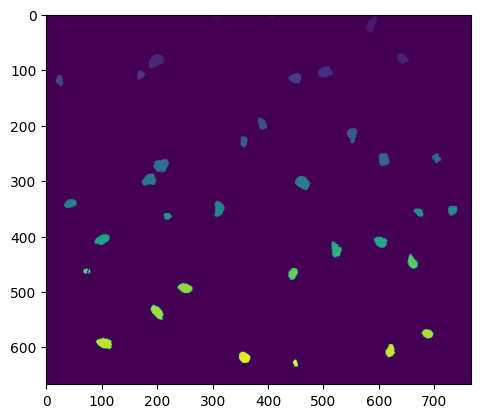

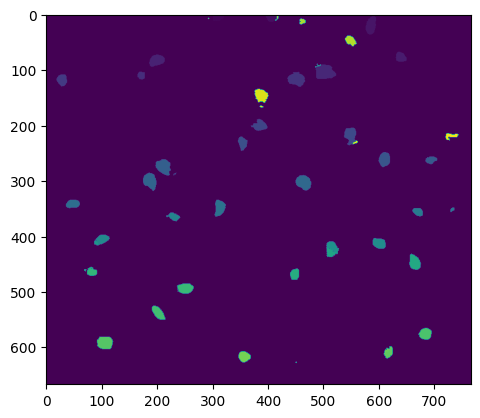

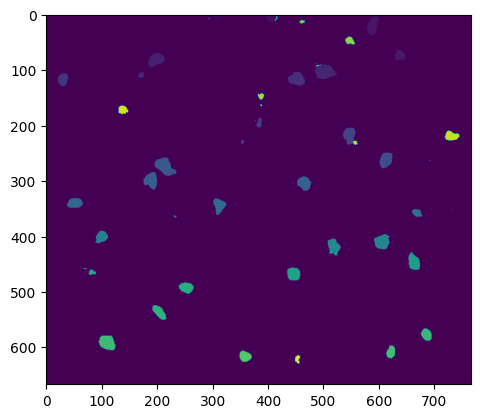

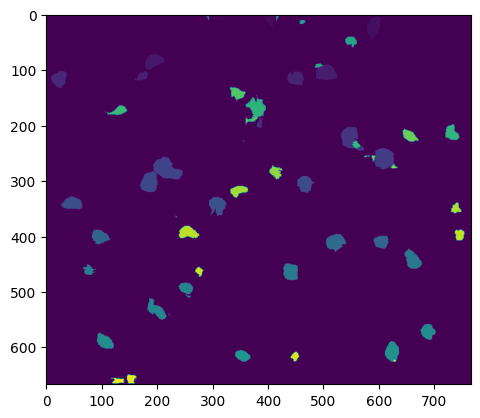

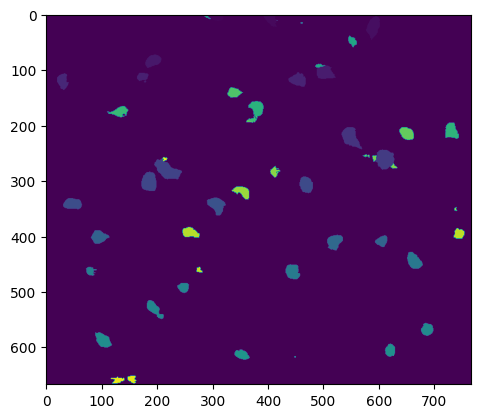

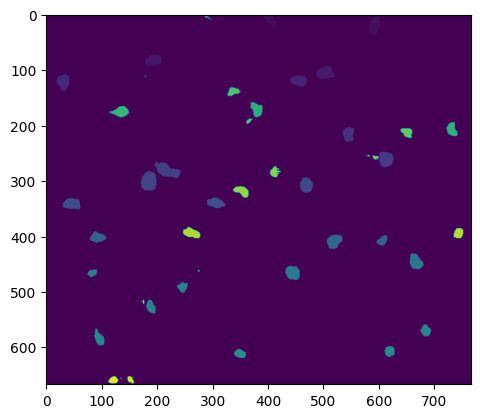

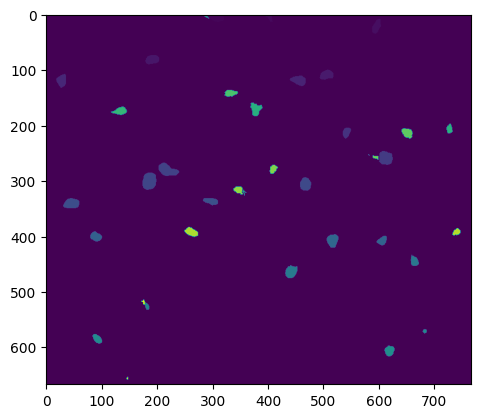

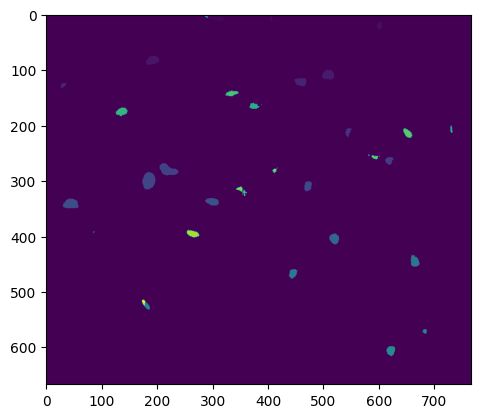

In [37]:
for mask in masks:
    plt.imshow(mask)
    plt.show()

In [36]:
mask = masks[3]

np.where(mask == 23)[0]
    

array([], dtype=int64)

In [31]:
from __future__ import annotations

def convertCellposeMaskToDictROICoordsXYCT(
masks       : np.ndarray[np.uint16, Tuple[int, int, int]], 
) -> Dict[AppKeys, Dict[int, Dict[int, Dict[Literal["xpix", "ypix", "med"], np.ndarray[np.int32]]]]]:
    dict_roi_coords_xyct = {}
    for t_plane, mask in enumerate(masks):
        dict_roi_coords_xyct[t_plane] = {}
        roi_num = np.max(mask)
        for roi_id in range(1, roi_num+1):
            print(roi_id)
            ypix, xpix = np.where(mask == roi_id)
            xpix, ypix = xpix.astype("uint16"), ypix.astype("uint16")

            med = (int(np.median(xpix)), int(np.median(ypix)))
            dict_roi_coords_xyct[t_plane][roi_id] = {"xpix": xpix, "ypix": ypix, "med": med}
    return dict_roi_coords_xyct

convertCellposeMaskToDictROICoordsXYCT(masks)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


Mean of empty slice.
invalid value encountered in scalar divide


ValueError: cannot convert float NaN to integer

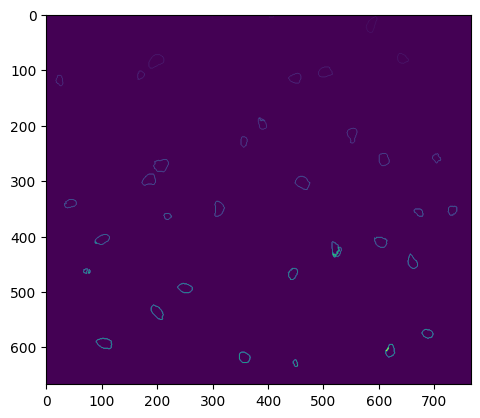

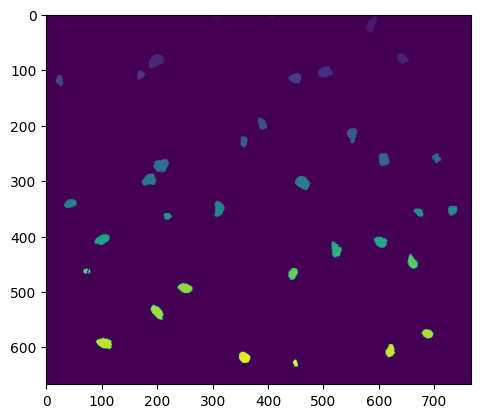

In [6]:
import numpy as np
import matplotlib.pyplot as plt

path_mask = "D:/optic/data/from_saito/cellpose_XYCT/AVG_MDA50_LD1_crop_seg.npy"

mask = np.load(path_mask, allow_pickle=True).tolist()
outlines = mask["outlines"]
masks = mask["masks"]

if not masks.ndim == 3:
    raise ValueError("masks should be generated with XYCT tiff stack !")


plt.imshow(outlines[0])
plt.show()

plt.imshow(masks[0])
plt.show()

In [38]:
# load ROI set of imageJ
from ij import IJ
from ij.plugin.frame import RoiManager
from ij.gui import PolygonRoi
from ij.gui import Roi
from java.awt import FileDialog

ModuleNotFoundError: No module named 'ij'